# StackOverFlow 

In [2]:
# general imports
# please make sure you have gensim (if you don't use: pip install gensim)
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import sys
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# classification imports 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
# Project definition - please change it to your working dir
from config import PROJECT_DIR as project_dir

## Load data

In [65]:
# first we did a basic cleaning for the data (removing NULLs mainly)
from clean_data import clean_data

clean_data(project_dir + '/data/Answers.csv', project_dir + '/data/Clean_Answers.csv')
clean_data(project_dir + '/data/Questions.csv', project_dir + '/data/Clean_Questions.csv')
clean_data(project_dir + '/data/Tags.csv', project_dir + '/data/Clean_Tags.csv')

ans = pd.read_csv(project_dir + '/data/Clean_Answers.csv')
qus = pd.read_csv(project_dir + '/data/Clean_Questions.csv')
tags = pd.read_csv(project_dir + '/data/Clean_Tags.csv')

##  First Observation on the data

In [5]:
ans.head(5)

,Id,OwnerUserId,CreationDate,ParentId,Score,IsAcceptedAnswer,Body
0,79741,3259.0,2008-09-17T03:43:22Z,79709,-1,False,<p>It's tough to say definitively without know...
1,79768,6043.0,2008-09-17T03:48:29Z,79709,9,False,<p>use variables in the outer function instead...
2,79779,8002.0,2008-09-17T03:49:36Z,79709,0,False,<p>Third approach: inner function returns a re...
3,79827,14257.0,2008-09-17T03:58:26Z,79709,1,False,"<p>I'm not sure I understand the question, but..."
4,79893,14928.0,2008-09-17T04:11:08Z,79709,6,False,"<p>Remember your Knuth. ""Premature optimizati..."


In [6]:
qus.head(5)

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,77434,14008.0,2008-09-16T21:40:29Z,171,How to access the last value in a vector?,<p>Suppose I have a vector that is nested in a...
1,95007,15842.0,2008-09-18T17:59:19Z,56,Explain the quantile() function in R,<p>I've been mystified by the R quantile funct...
2,255697,1941213.0,2008-11-01T15:48:30Z,4,Is there an R package for learning a Dirichlet...,<p>I'm looking for a an <code>R</code> package...
3,359438,2173.0,2008-12-11T14:02:06Z,4,Optimization packages for R,<p>Does anyone know of any optimization packag...
4,439526,37751.0,2009-01-13T15:58:48Z,23,Thinking in Vectors with R,<p>I know that R works most efficiently with v...


In [7]:
tags.head(5)

,Id,Tag
0,77434,vector
1,79709,memory
2,79709,function
3,79709,global-variables
4,79709,side-effects


In [ ]:
# The two next cells were not originally here - the main function creates all the features after we tuned their parametes
# The cell after it load the dataframes.Running the main might take several hours, so it better load the 2 dataframes. It's in
# early stage in the notebook because it can save you some time later... 
import main
main.main()

In [17]:
# loading dataframes
train_df = pd.read_csv(project_dir + '/train_with_tag_clusters_and_user_scores.csv')
test_df = pd.read_csv(project_dir + '/test_with_tag_clusters_and_user_scores.csv')

## Some basic feature analysis

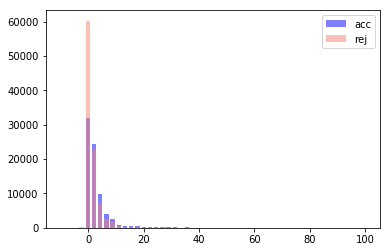

In [78]:
# Score of answer seems to be a very strong feature for example - most of answers with score 0 was rejected
train_df = pd.read_csv(project_dir + '/train_with_tag_clusters_and_user_scores.csv')
acc_df = train_df[train_df['IsAcceptedAnswer'] == True]
rej_df = train_df[train_df['IsAcceptedAnswer'] == False]

bins = np.linspace(-10, 100, 50)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['Score_ans'] if x < 100], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['Score_ans'] if x < 100], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()

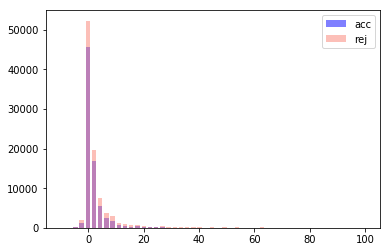

In [79]:
# question score - weaker feature
bins = np.linspace(-10, 100, 50)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['Score_qus'] if x < 100], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['Score_qus'] if x < 100], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()

## Creating users list and graph

In [18]:
# This is also might take a time ~ 2 hours
from create_user_profile import *
users = list_of_users(train_df)
users.create_user_graph()
users.set_node_properties()
users.set_user_scores(train_df)

In [19]:
#generating and saving the objects - user's features are in different module
user_df = users.generate_data_frame(project_dir + "\user_dataframe.csv")
users.save_obj(project_dir + "\user_list.pkl")

## User's graph analysis

In [21]:
G = list_of_users.load_obj(project_dir + '\user_list.pkl')

#### devide to sub graphs and some details of the graph

In [22]:
sub_graphs = list(nx.weakly_connected_component_subgraphs(G.graph))

2425 157144 53956


#### Largest components - most of the users are connected in the same component

In [23]:
# There is a one big ginat component and many other small components
sorted([len(x) for x in sub_graphs])[-10:]

[5, 5, 5, 5, 5, 5, 6, 6, 8, 50018]

## User's Features testing

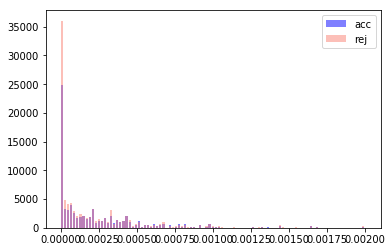

In [87]:
# rejected users are mostly not 'popular' - whiche means other people don't answer them often (the 0 column shows that)
bins = np.linspace(0, 0.002, 100)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['in_degree_user'] if x < 0.002], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['in_degree_user'] if x < 0.002], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()



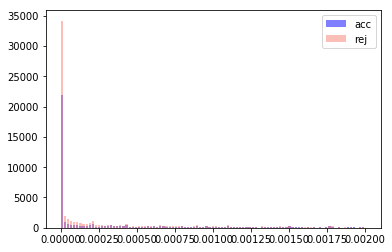

In [88]:
# and also, rejected question are also of users that don't reply to other users on questions
bins = np.linspace(0, 0.002, 100)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['out_degree_user'] if x < 0.002], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['out_degree_user'] if x < 0.002], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()

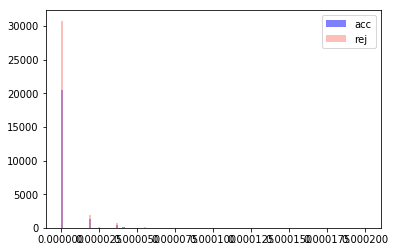

In [93]:
# and also, rejected question are also of users that don't reply to other users on questions
bins = np.linspace(0, 0.0002, 100)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['closeness_centrality_user'] ], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['closeness_centrality_user'] ], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()

## NLP FEATURES

#### cleaning data

In [3]:
# removing stop words - in the module we clean also words related to the structure of the post
import nltk
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
print stopWords

set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'o', u'hadn', u'herself', u'll', u'had', u'should', u'to', u'only', u'won', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'd', u'did', u'didn', u'this', u'she', u'each', u'further', u'where', u'few', u'because', u'doing', u'some', u'hasn', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'while', u're', u'does', u'above', u'between', u'mustn', u't', u'be', u'we', u'who', u'were', u'here', u'shouldn', u'hers', u'by', u'on', u'about', u'couldn', u'of', u'against', u's', u'isn', u'or', u'own', u'into', u'yourself', u'down', u'mightn', u'wasn', u'your', u'from', u'her', u'their', u'aren', u'there', u'been', u'whom', u'too', u'wouldn', u'themselves', u'weren', u'was', u'until', u'more', u'himself', u'that', u'but', u'don', u'with', u'than', u'those', u'he', u'me', u'myself', u'ma', u'these', u'up', u'will', u'below', u'ain

In [1]:
import gensim
Lda = gensim.models.ldamodel.LdaModel
from gensim import corpora

C:\Users\Gal\Anaconda2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
# this how to generate topics for questions and answers - also it might take a while... It's better see the relevant module
from nlp_features import *
train_df = pd.read_csv(project_dir + '/train_with_tag_clusters_and_user_scores.csv')
q_docs = train_df['clean_qus']
a_docs = train_df['clean_ans']

q_docs = [x.split(" ") for x in q_docs if type(x)!=float]
a_docs = [x.split(" ") for x in a_docs if type(x)!=float]

q_dictionary = corpora.Dictionary(q_docs)
q_doc_term_matrix = [q_dictionary.doc2bow(doc) for doc in q_docs]

a_dictionary = corpora.Dictionary(a_docs)
a_doc_term_matrix = [a_dictionary.doc2bow(doc) for doc in a_docs]

Lda = gensim.models.ldamodel.LdaModel

print "building a model for questions"
q_ldamodel = Lda(q_doc_term_matrix, num_topics=10, id2word=q_dictionary, passes=50)
q_ldamodel.save("my_lda_model_qus_10_topics")

print "building a model for answers"
a_ldamodel = Lda(a_doc_term_matrix, num_topics=10, id2word=a_dictionary, passes=50)
a_ldamodel.save("my_lda_model_ans_10_topics")

building a model for questions
building a model for answers


#### veryfining that topics make sense

In [12]:
for x in a_ldamodel.print_topics(num_topics=10, num_words=20):
    print x

(0, u'0.017*"~" + 0.014*"number" + 0.014*"matrix" + 0.014*"data" + 0.011*"time" + 0.011*"values" + 0.010*"vector" + 0.010*"model" + 0.010*"value" + 0.008*"element" + 0.008*"length" + 0.006*"first" + 0.005*"test" + 0.005*"calculate" + 0.005*"two" + 0.005*"random" + 0.005*"mean" + 0.005*"returns" + 0.005*"function" + 0.005*"/"')
(1, u'0.103*"1" + 0.098*"2" + 0.072*"3" + 0.062*"na" + 0.053*"4" + 0.041*"5" + 0.033*"b" + 0.031*"6" + 0.021*"7" + 0.021*"8" + 0.020*"c" + 0.018*"10" + 0.016*"9" + 0.010*"x" + 0.010*"$" + 0.010*"12" + 0.009*"11" + 0.007*"id" + 0.007*"13" + 0.006*"15"')
(2, u'0.042*"image" + 0.041*"description" + 0.035*"*" + 0.023*"plot" + 0.021*"x" + 0.014*"color" + 0.012*"size" + 0.012*"fill" + 0.011*"labels" + 0.010*"add" + 0.010*"max" + 0.010*"/" + 0.010*"mean" + 0.010*"col" + 0.009*"label" + 0.008*"min" + 0.008*"p" + 0.008*"width" + 0.007*"points" + 0.007*"use"')
(3, u'0.019*"function" + 0.019*"use" + 0.012*"like" + 0.012*"would" + 0.011*"want" + 0.010*"need" + 0.010*"code" +

In [14]:
for i in range(10):
    bow = a_dictionary.doc2bow(a_docs[i])
    t = a_ldamodel.get_document_topics(bow)
    print t

[(3, 0.70084924), (8, 0.28314927)]
[(0, 0.39112002), (1, 0.025), (2, 0.02500137), (3, 0.40887052), (4, 0.025), (5, 0.025), (6, 0.025002552), (7, 0.025), (8, 0.025005588), (9, 0.025)]
[(0, 0.12699741), (2, 0.22358847), (3, 0.49486497), (7, 0.10000015)]
[(0, 0.21933755), (3, 0.38200584), (8, 0.3448088)]
[(1, 0.40886503), (7, 0.4306464), (8, 0.12714858)]
[(0, 0.17579961), (1, 0.49311706), (2, 0.045494415), (3, 0.25570112), (5, 0.020795628)]
[(0, 0.18219188), (1, 0.014285768), (2, 0.014286166), (3, 0.7035199), (4, 0.014285714), (5, 0.014285714), (6, 0.014286555), (7, 0.014285775), (8, 0.014286356), (9, 0.014286191)]
[(0, 0.07689339), (3, 0.54721534), (4, 0.061111346), (8, 0.28143942)]
[(3, 0.6876724), (6, 0.2395936)]
[(3, 0.8194172), (8, 0.1570521)]


### Some properties of NLP features

#### verifying that scores to each doc makes sense

In [3]:
from nlp_features import *
train_df = pd.read_csv(project_dir + '/train_with_tag_clusters_and_user_scores.csv')
accept_df = train_df [train_df ['IsAcceptedAnswer'] == True]
reject_df = train_df [train_df ['IsAcceptedAnswer'] == False]

print len(accept_df), len(reject_df)

D_accept = find_correlations_in_topics(accept_df)
D_reject = find_correlations_in_topics(reject_df)



C:\Users\Gal\Anaconda2\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


76908 96962


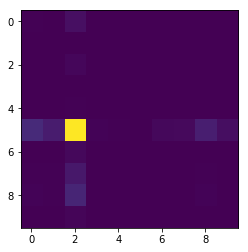

In [24]:
# graphs in this section is a bit differnet from the one in the doc since we have changed the order of the topics a bit - basically only the order is changed 
# graph that compares topics of questions and answers in where the answer was accepted  
im_accept = [[D_accept[(i, j)] for i in range(10)] for j in range(10)]
plt.imshow(im_accept)

plt.show()

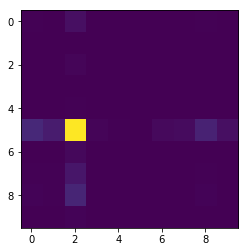

In [25]:
# graph that compares topics of questions and answers in where the answer was rejected
im_reject = [[D_reject[(i, j)] for i in range(10)] for j in range(10)]
plt.imshow(im_reject)

plt.show()

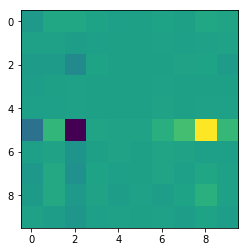

In [34]:
# graph that compares topics of questions and answers in where the answer in the diff - we can see that there is one spot
# that combination of topics was much stronger in accepted answers and one in the rejected,which means, there is some
# information in this feature - not strong as we wanted :( - more information in the document
ratio = len(accept_df) / float(len(reject_df))
im_dif = [[D_reject[(i, j)]*ratio - D_accept[(i, j)]for i in range(10)] for j in range(10)]
plt.imshow(im_dif)

plt.show()

## Classification

In [5]:
# classification imports 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# In the first time we tryed to classify we didn't have the time and tags features - we used those cells several times for the
# classification testing - The NN is in different module since it requires tensorflow envionment
train_df = pd.read_csv(project_dir + '/train_with_tag_clusters_and_user_scores.csv')
test_df = pd.read_csv(project_dir + '/test_with_tag_clusters_and_user_scores.csv')

train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [8]:
# NN tests are in different module since we need tensorflow enviornment 
# define all features
basic_features = ['Score_ans', 'Score_qus']
nlp_features = ['topic_' + str(i) + "_qus" for i in range(10)] + ['topic_' + str(i) + "_ans" for i in range(10)]
time_features = ['diff_percentile_bucket', 'hirerchy']
tags_features = ["cluster_" + str(i) for i in range(50)] + ["user_score_cluster_" + str(i) for i in range(50)]\
                + ["user_score_general","total_score_user_question_by_clusters", "total_score_user_question_by_clusters_relative"]
users_features = ['neg_answers_user', 'neg_questions_user', 'number_of_answers_user', 'out_degree_user', 'question_total_score_user',
                 'answer_total_score_user', 'closeness_centrality_user', 'in_degree_user']

# after several tries we found out that NLP and tags features confuse the classifiers and they have better prediction without them 
all_features = basic_features + users_features + time_features  # +  nlp_features # + tags_features
target = 'IsAcceptedAnswer'

# training - random forest
random_forest_clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)
random_forest_clf.fit(train_df[all_features], train_df[target].astype(int))
results_random_forest = random_forest_clf.predict(test_df[all_features].astype(int))

correct_predictions = np.sum(results_random_forest == np.array(test_df[target].astype(int)))

print "results of random forest:"
print (correct_predictions) / float(len(results_random_forest))

# training - logistic regression
# Iterated over parameters: pentalty {l1, l2}
logisticRegr = LogisticRegression(max_iter=5000, class_weight='balanced', penalty='l2')
logisticRegr.fit(train_df[all_features], train_df[target].astype(int))
correct_predictions = np.sum(logisticRegr.predict(test_df[all_features].astype(int)) == test_df[target].astype(int))

print "results of logistic regression:"
print correct_predictions / float(len(test_df[target]))


results of random forest:
0.7314273425003697
results of logistic regression:
0.7078645644313615


In [11]:
# Please notice that in one of the presentations we claimed we got 75% prediction, that because we has a bug in user's featuers.
# feature importance - include NLP features - Tags features got the lowest importances
importances = random_forest_clf.feature_importances_
for i in range(len(importances)):
    print all_features[i], importances[i]

Score_ans 0.23541238877919013
Score_qus 0.045579366578782206
neg_answers_user 0.0010445348848559792
neg_questions_user 0.0025877259741308003
number_of_answers_user 0.00821318150235062
out_degree_user 0.03489633102054453
question_total_score_user 0.011728279666331711
answer_total_score_user 0.009709149961849092
closeness_centrality_user 0.008730542995623446
in_degree_user 0.008624900506589985
diff_percentile_bucket 0.09681089138527789
hirerchy 0.4458798058206593
topic_0_qus 0.004957590282334831
topic_1_qus 0.003102871132859473
topic_2_qus 0.004643773905488897
topic_3_qus 0.003968582841880785
topic_4_qus 0.0034283624780066
topic_5_qus 0.00603374509619582
topic_6_qus 0.004184243261242693
topic_7_qus 0.004700090907157172
topic_8_qus 0.004403005585167345
topic_9_qus 0.004251939065643405
topic_0_ans 0.0074160400907871205
topic_1_ans 0.005126388447220235
topic_2_ans 0.005945197515262719
topic_3_ans 0.004034423205381385
topic_4_ans 0.0034209166856662915
topic_5_ans 0.003328966684776959
topic_6

In [9]:
# training - SVM - this takes a bit longer so it's in a different cell
clf = svm.SVC()
clf.fit(train_df[all_features], train_df[target]) 
correct_predictions = np.sum(clf.predict(test_df[all_features]) == test_df[target])

print "results of SVM:"
print correct_predictions / float(len(test_df[target]))

results of SVM:
0.7148675349812492


In [6]:
# sadly in the end we saw that we get the same results with some of the basic features.
basic_features = ['Score_ans', 'Score_qus']
time_features = ['diff_percentile_bucket', 'hirerchy']

important_features = time_features + basic_features
target = 'IsAcceptedAnswer'

random_forest_clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)
random_forest_clf.fit(train_df[important_features], train_df[target].astype(int))
results_random_forest = random_forest_clf.predict(test_df[important_features].astype(int))

correct_predictions = np.sum(results_random_forest == np.array(test_df[target].astype(int)))

print "results of random forest:"
print (correct_predictions) / float(len(results_random_forest))

results of random forest:
0.7332419317983252


## time and hierarchy features 

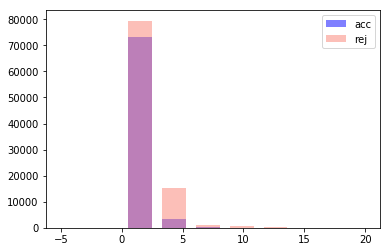

In [81]:
# hirerchy - strong feature, we constructed it after first basic features were not good enogh, the construction itself can
# seen in the relevant module - here we checked the quality of the feature
bins = np.linspace(-5, 20, 10)
width = 0.7 * (bins[1] - bins[0])

plt.hist([x for x in acc_df['hirerchy'] if x < 100], bins, alpha = 0.5, width=width, color='blue', label = 'acc')
plt.hist([x for x in rej_df['hirerchy'] if x < 100], bins, alpha = 0.5, width=width, color='salmon', label = 'rej')
plt.legend(loc ='upper right')
plt.show()

## Tagging features

In [1]:
# Those features were constructed and checked in a different module, their check was by observing the words in each cluster
# and making sure it makes sense. It was written in a different module sice it required a lot of preperations, here are some of the results.

## Spectral clustering of tags:
![title](img/tagsSpectralClustering.png)